In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import random 
from tqdm import tqdm 
from math import ceil, floor
from datetime import datetime 
#from tdqm import tdqm 
torch.manual_seed(123)

# Device

In [3]:
#device = (torch.device('mps') if torch.mps.is_available() else torch.device('cpu'))
device = torch.device("cpu")
print(f"Training on device {device}.")


Training on device cpu.


# Model definition

In [ ]:
## Input image = 48 x 60
## Output size = 10 classes (one for each digit) + 5 = 15 

class MyCNN(nn.Module):
    
    def __init__(self, num_classes=10):
        super(MyCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 3, padding = 1), # (64, 1, 48, 60) -> (64, 32, 48, 60 )
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2 , stride = 2), # (64, 32, 48, 60 ) -> (64, 32, 24, 30)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (32, 14, 14) → (64, 7, 7)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # (64, 7, 7) → (128, 3, 3)
        )

        self.fc = nn.Sequential(
            nn.Linear(128 * 6 * 7, 256),
            nn.ReLU(),
            nn.Linear(256, 15)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the feature maps into a vector
        x = self.fc(x)
        return x

class MyConvOnlyCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(MyConvOnlyCNN, self).__init__()
        self.features = nn.Sequential(
            # Input: (batch_size, 1, 48, 60)
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # -> (batch_size, 32, 48, 60)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),        # -> (batch_size, 32, 24, 30)
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # -> (batch_size, 64, 24, 30)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),        # -> (batch_size, 64, 12, 15)
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # -> (batch_size, 128, 12, 15)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)         # -> (batch_size, 128, 6, 7)
        )
        
        # Final convolution with a kernel that spans the entire spatial size (6x7)
        # This produces an output of shape (batch_size, 15, 1, 1)
        self.conv_out = nn.Conv2d(128, 15, kernel_size=(6, 7))
    
    def forward(self, x):
        x = self.features(x)
        x = self.conv_out(x)
        x = x.view(x.size(0), -1)  # Flatten to shape (batch_size, 15)
        return x

## Localization


In [4]:
def localization_loss(y_pred, y_true):
    bce_loss_fn = nn.BCEWithLogitsLoss(reduction='none')
    mse_loss_fn = nn.MSELoss(reduction='none')
    ce_loss_fn = nn.CrossEntropyLoss(reduction='none')
    
    # Convert target for continuous losses to double
    det_target = y_true[:, 0].to(dtype=y_pred.dtype)
    bbox_target = y_true[:, 1:5].to(dtype=y_pred.dtype)
    
    det_loss = bce_loss_fn(y_pred[:, 0], det_target)
    loc_loss = mse_loss_fn(y_pred[:, 1:5], bbox_target).mean(dim=1)
    class_loss = ce_loss_fn(y_pred[:, 5:], y_true[:, 5].long())
    
    condition = y_true[:, 0].bool()
    total_loss = torch.where(condition, det_loss + loc_loss + class_loss, det_loss)
    
    return total_loss.mean()


# Computing mean and standard deviation

In [5]:
def calculate_mean_std(data):
    num_img = 0
    mean_sum = 0.0
    std_sum = 0.0

    for img, _ in data:
        mean_sum += img.mean().item()
        std_sum += img.std().item()
        num_img +=1
    
    mean = mean_sum / num_img 
    std = std_sum / num_img

    return torch.tensor(mean), torch.tensor(std)

train = torch.load("data_loc/localization_train.pt")
mean, std = calculate_mean_std(train)
print(f"Mean: {mean}")
print(f"Std: {std}")


/var/folders/6t/376dzz3552sbcyyx1b7h7yfm0000gn/T/ipykernel_6459/4034139965.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train = torch.load("data_loc/localization_tra

Mean: 0.41708362102508545
Std: 0.2124161422252655


### Load data and preprocessing

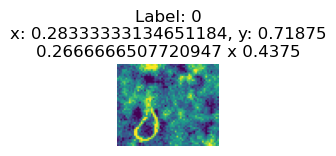

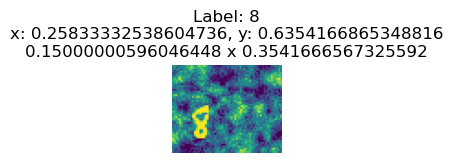

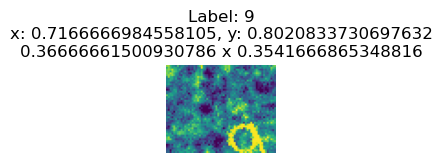

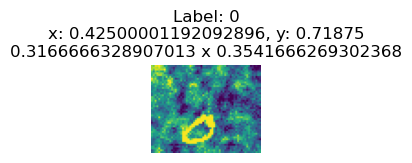

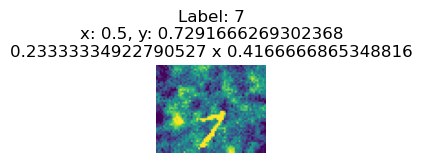

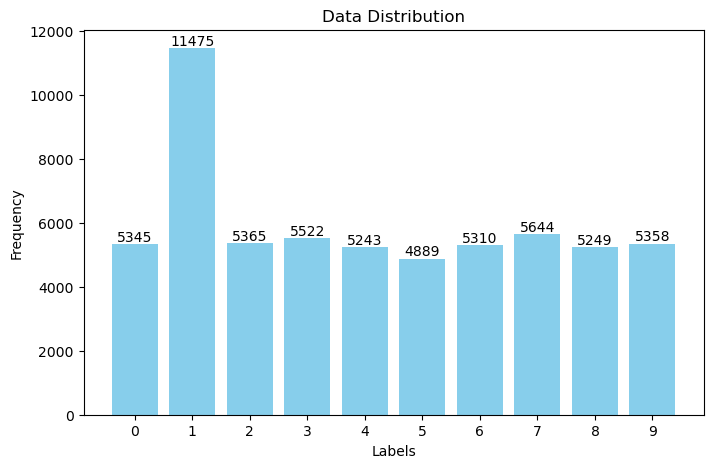

{0.0: 5345,
 1.0: 11475,
 2.0: 5365,
 3.0: 5522,
 4.0: 5243,
 5.0: 4889,
 6.0: 5310,
 7.0: 5644,
 8.0: 5249,
 9.0: 5358}

In [6]:
def data_distribution(data):
    """
    Plots the distribution of the given data across the labels with labels and counts.
    """
    
    labels = [label[5] for _, label in data]  # Assuming label[5] contains the class label
    
    # Calculate distribution using numpy
    unique_labels, counts = np.unique(labels, return_counts=True)
    distribution = dict(zip(unique_labels, counts))
    
    x_labels = [str(int(label)) for label in unique_labels]  # Convert to string for plotting
    
    # Visualize the label distribution using a bar chart
    plt.figure(figsize=(8, 5))
    bars = plt.bar(x_labels, counts, color='skyblue')
    
    # Add text on top of each bar to display count
    for bar, count, label in zip(bars, counts, x_labels):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                 f"{count}", ha='center', va='bottom', fontsize=10)

    plt.xlabel('Labels')
    plt.ylabel('Frequency')
    plt.title('Data Distribution')
    plt.show()
    
    return distribution


def visualize_random_images(data, num_images):
    """
    Visualizes random images from the data
    """
    indices = random.sample(range(len(data)), num_images)
    samples = [data[i] for i in indices]
    # Set up the figure
    plt.figure(figsize=(6, 4))
    
    # Loop over the selected samples
    for i, (img, label) in enumerate(samples):
        digit = int(label[5])
        x, y, w, h = label[1], label[2], label[3], label[4]
        

        plt.subplot(1, num_images, i+1)
        
        # If the image is a tensor, convert it to a numpy array for plotting.
        if torch.is_tensor(img):
            # Convert from (C, H, W) to (H, W, C)
            img = img.permute(1, 2, 0).numpy()
            
        plt.imshow(img)
        title_str = f"Label: {digit}\nx: {x}, y: {y}\n{w} x {h}"
        plt.title(title_str)
        plt.axis('off')
    
        plt.tight_layout()
        plt.show()

visualize_random_images(train, 5)
data_distribution(train)

### Normalize Images

In [7]:
class LocalizationDataset(Dataset):
    def __init__(self, file_path, preprocessor=None):
        self.data = torch.load(file_path)
        self.preprocessor = preprocessor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image, label = self.data[index]
        
        if self.preprocessor:
            image = self.preprocessor(image)
            
        return image, label

preprocessor = transforms.Compose([
    transforms.Normalize(mean=[mean], std=[std])
])

train_dataset = LocalizationDataset("data_loc/localization_train.pt", preprocessor = preprocessor)
val_dataset = LocalizationDataset('data_loc/localization_val.pt', preprocessor = preprocessor)
test_dataset = LocalizationDataset('data_loc/localization_test.pt', preprocessor = preprocessor)

/var/folders/6t/376dzz3552sbcyyx1b7h7yfm0000gn/T/ipykernel_6459/2198379218.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data = torch.load(file_path)


### Training

In [8]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

def train(n_epochs, optimizer, model, loss_fn, train_loader):
    """
    Train our model and save weight values
    """
    n_batch = len(train_loader)
    losses_train = []
    model.train()
    optimizer.zero_grad(set_to_none=True)
    
    weight_values = []
    bias_values = []
    
    for epoch in range(1, n_epochs + 1):
        
        loss_train = 0.0
        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{n_epochs}", leave=False):

            # We use torch.double to get the same results as Pytorch
            model = model.to(torch.double)
            imgs = imgs.to(device=device, dtype=torch.double) 
            labels = labels.to(device=device)

            outputs = model(imgs)
            
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()
            
        losses_train.append(loss_train / n_batch)
        
        # Here we store weight values at each step of the training process
        with torch.no_grad():
            weight_values.append(model.features[0].weight.data.clone().detach())
            if model.features[0].bias is not None:
                bias_values.append(model.features[0].bias.data.clone().detach())

        print('{}  |  Epoch {}  |  Training loss {:.5f}'.format(
            datetime.now().time(), epoch, loss_train / n_batch), flush=True)
    return weight_values, bias_values


model = MyCNN()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=1e-4)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
loss_fn = localization_loss

weigths, biases = train(
    n_epochs=5,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

18:40:06.651494  |  Epoch 1  |  Training loss 1.22647


KeyboardInterrupt: 

### Predictions

In [25]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes

def unnormalize(image, mean, std):
    mean = torch.tensor(mean, device=image.device).view(-1, 1, 1)
    std = torch.tensor(std, device=image.device).view(-1, 1, 1)
    return image * std + mean

def convert_box(box, H, W):
    # Convert normalized [x, y, w, h] (center format) to [x_min, y_min, x_max, y_max] in pixel coordinates
    x, y, w, h = box  
    x_center = x * W
    y_center = y * H
    box_w = w * W
    box_h = h * H
    x_min = x_center - box_w / 2
    y_min = y_center - box_h / 2
    x_max = x_center + box_w / 2
    y_max = y_center + box_h / 2
    return torch.tensor([x_min, y_min, x_max, y_max], device=box.device)

def visualize_predictions(model, image, label, preprocessor=None, mean=[0.0], std=[1.0], detection_threshold=0.5):
    model.eval()
    device = next(model.parameters()).device

    image_proc = preprocessor(image) if preprocessor else image.clone()
    image_proc = image_proc.unsqueeze(0).to(device, dtype = torch.double)

    with torch.no_grad():
        outputs = model(image_proc)

    pred = outputs[0]
    pred_pc = torch.sigmoid(pred[0]).item()
    pred_box = pred[1:5]
    pred_class = torch.argmax(pred[5:]).item()

    gt_pc = label[0].item()
    gt_box = label[1:5]
    gt_class = int(label[5].item())

    image_disp = unnormalize(image, mean, std)
    image_disp = (image_disp.clamp(0, 1) * 255).to(torch.uint8)
    if image_disp.shape[0] == 1:
        image_disp = image_disp.repeat(3, 1, 1)
    _, H, W = image_disp.shape

    pred_box_pixels = convert_box(pred_box, H, W)
    gt_box_pixels = convert_box(gt_box, H, W)

    # Prepare lists for boxes, colors, and labels for drawing both predicted and ground truth boxes
    boxes = []
    colors = []
    #labels_text = []
    
    if pred_pc > detection_threshold:
        boxes.append(pred_box_pixels)
        colors.append("red")

    
    if gt_pc > 0.5:
        boxes.append(gt_box_pixels)
        colors.append("green")

    
    if boxes:
        boxes = torch.stack(boxes)
        image_with_boxes = draw_bounding_boxes(image_disp, boxes, colors=colors, width=1)
    else:
        image_with_boxes = image_disp

    image_np = image_with_boxes.permute(1, 2, 0).cpu().numpy()

    plt.figure(figsize=(6, 6))
    plt.imshow(image_np)
    plt.axis("off")
    plt.title("Prediction vs Ground Truth")
    # Create a caption with prediction details and ground truth info
    caption = (f"Prediction: Class {pred_class} (Prob: {pred_pc:.2f}) | "
               f"Ground Truth: Class {gt_class}")
    # Place caption below the image
    plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=12)
    plt.show()






### Model selection and evaluation

Val Accuracy: 0.0979
Val Mean IoU: 0.0077


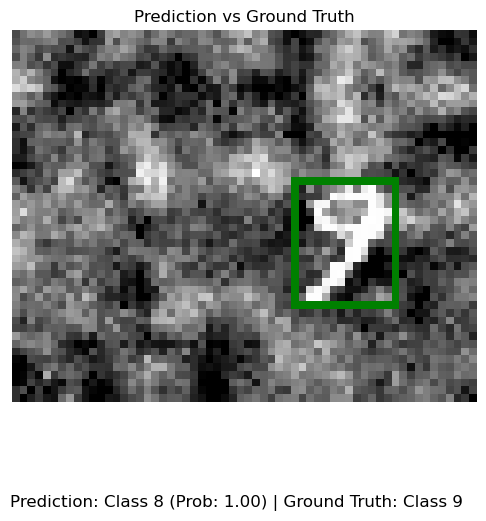

In [29]:
def intersection(bb1, bb2):
    #Converting to corner coordinates
    x1_min, y1_min = bb1[0] - bb1[2] / 2, bb1[1] - bb1[3] / 2
    x1_max, y1_max = bb1[0] + bb1[2] / 2, bb1[1] + bb1[3] / 2

    x2_min, y2_min = bb2[0] - bb2[2] / 2, bb2[1] - bb2[3] / 2
    x2_max, y2_max = bb2[0] + bb2[2] / 2, bb2[1] + bb2[3] / 2

    x_min = max(x1_min, x2_min)
    y_min = max(y1_min, y2_min)
    x_max = min(x1_max, x2_max)
    y_max = min(y1_max, y2_max)

    w_int = max(0, x_max - x_min)
    h_int = max(0, y_max - y_min)

    return w_int * h_int

def union_area(bb1, bb2):
    # Area of the boxes
    area_1 = bb1[2] * bb1[3]
    area_2 = bb2[2] * bb2[3] 

    union = area_1 + area_2 - intersection(bb1, bb2)

    return union

def IoU(bb1, bb2):
    intersection_area = intersection(bb1, bb2)
    union = union_area(bb1, bb2)
    
    return intersection_area/union
    
   
def compute_IoU_localization(model, loader, preprocessor):
    model.eval()
    total_iou = 0
    num_samples = 0

    with torch.no_grad():
        for images, labels in loader:
            if preprocessor:
                images = preprocessor(images)
            
            images = images.to(device, dtype=torch.double)
            labels = labels.to(device)

            outputs = model(images)

            mask = (labels[:, 0] == 1)
            if mask.sum() == 0:
                continue

            pred_boxes = outputs[mask, 1:5]
            true_boxes = labels[mask, 1:5]

            batch_iou = []
            for i in range(len(images)):
                iou_value = IoU(pred_boxes[i], true_boxes[i])
                batch_iou.append(iou_value)
            
            total_iou += sum(batch_iou)
            num_samples += len(images)
            
    return total_iou/num_samples


def compute_accuracy_localization(model, loader, preprocessor):
    model.eval()
    num_correct = 0
    num_samples = 0
        
    with torch.no_grad():
        for images, labels in loader:
            if preprocessor:
                images = preprocessor(images)
            
            images = images.to(device, dtype=torch.double)
            labels = labels.to(device)

            outputs = model(images)
            mask = (labels[:, 0] == 1)
            if mask.sum() == 0:
                continue
            class_probs = torch.softmax(outputs[mask, 5:], dim=1)
            class_pred = torch.argmax(class_probs, dim=1)
            class_true = labels[mask, 5].long()

            num_correct += (class_pred == class_true).sum().item()
            num_samples += mask.sum().item()
    
    return num_correct/num_samples

val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
model.eval()
accuracy = compute_accuracy_localization(model, val_loader, preprocessor)
mean_iou = compute_IoU_localization(model, val_loader, preprocessor)

print(f"Val Accuracy: {accuracy:.4f}")
print(f"Val Mean IoU: {mean_iou:.4f}")

# Sample usage:
sample_image, sample_label = val_dataset[7]
visualize_predictions(model, sample_image, sample_label, preprocessor, mean=[mean.item()], std=[std.item()])

# Model selection and evaluation

In [ ]:
# Pipeline for training different models and picking the best one
# based on performance on val data 

#def model_selection()

import itertools
import torch.optim

# Define a list of hyperparameter values to search over
learning_rates = [0.001, 0.0005, 0.0001]
weight_decays = [0, 0.01, 0.001]

# List of model classes to test
models = [MyCNN, MyConvOnlyCNN]

best_model = None
best_score = 0
best_hyperparams = {}

# Loop over each model type
for model_class in models:
    # Loop over all combinations of learning rate and weight decay
    for lr, wd in itertools.product(learning_rates, weight_decays):
        print(f"Training {model_class.__name__} with lr={lr}, weight_decay={wd}")
        # Instantiate a new model
        model = model_class()
        
        # Create an optimizer with the current hyperparameters
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        
        # Train the model
        weights, biases = train(
            n_epochs=5,
            optimizer=optimizer,
            model=model,
            loss_fn=loss_fn,
            train_loader=train_loader)
        
        # Evaluate the model
        model.eval()
        accuracy = compute_accuracy_localization(model, val_loader, preprocessor)
        mean_iou = compute_IoU_localization(model, val_loader, preprocessor)
        
        combined_performance = (accuracy + mean_iou) / 2
        
        print(f"Combined performance: {combined_performance:.4f}")
        
        # Update best model and hyperparameters if performance improved
        if combined_performance > best_score:
            best_score = combined_performance
            best_model = model
            best_hyperparams = {
                'model': model_class.__name__,
                'lr': lr,
                'weight_decay': wd
            }

print("Best hyperparameters:", best_hyperparams)
print("Best combined performance:", best_score)

# Test best model on test data
#test_accuracy = compute_accuracy_localization(model, test_loader, preprocessor)
#test_mean_iou = compute_IoU_localization(model, test_loader, preprocessor)
    
#test_combined_performance = (accuracy + mean_iou) / 2

    
    

